# Loading the training data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
from keras.models import load_model
import tensorflow as tf
from sklearn import preprocessing
from skimage import exposure
from os import listdir
from scipy import misc
import csv
from math import *
import random
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import *
import json


%matplotlib inline

full_df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
NORM_W = 32
NORM_H = 32

for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    full_df = pd.concat([full_df, df_csv])
    

full_label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        full_label_names.append(row[1])

del full_label_names[0]

print ('Label names', full_label_names)
print ('\n\nPoints in set:', len(full_df))

df, label_names = full_df, full_label_names

Label names ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric to

# Reducing the set
If you want to use the full set (43 type of signs), skip this cell.

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


class_id_set: [29, 18, 9, 4, 38, 33, 21, 17, 36, 30]


Signs: ['Bicycles crossing', 'General caution', 'No passing', 'Speed limit (70km/h)', 'Keep right', 'Turn right ahead', 'Double curve', 'No entry', 'Go straight or right', 'Beware of ice/snow']


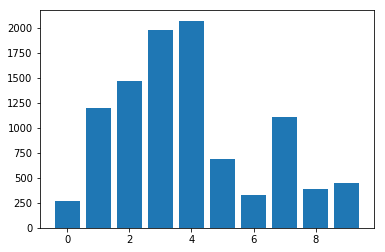

In [2]:
## This for reducing the set -- for test reasons


def reduce_set(class_id_set):
    tdf = pd.DataFrame()
    t_label_names = []
    for i, class_id in enumerate(class_id_set):
        selected = full_df[full_df['ClassId'] == class_id]
        selected['ClassId'] = i
        tdf = pd.concat((tdf, selected))
        t_label_names.append(full_label_names[class_id])
    return tdf, t_label_names

df_container = widgets.Text()
label_names_container = widgets.Text()

@interact(n=widgets.IntSlider(min=2, max=len(full_label_names),step=1,value=10, description="Reduce set to N type of signs"))
def set_size(n):
    class_id_set = random.sample(range(len(full_label_names)), n)
    df, label_names = reduce_set(class_id_set)
    df_container.value = json.dumps(df.values.tolist()[:])
    label_names_container.value = json.dumps(label_names)
    
    print ("class_id_set:", class_id_set )
    print ("\n\nSigns:", label_names)
    class_ids, count = np.unique(df['ClassId'].values, return_counts=True)
    plt.bar(class_ids, count)
    




In [3]:
# this is a trick to get the text-field bound values back to the main dataframe and label_names list
# from the slider in the previous cell
#
# If you don't run the previous cell, DON'T RUN IT
df = pd.DataFrame(data = json.loads(df_container.value), columns = df.columns.values)
label_names = json.loads(label_names_container.value)



# Training and test sets
A part of dataset is used to validation, so it's not used for training.

In [5]:
# training and test sets
# shuffling the samples
df = df.sample(frac=1)

TEST_PROP = 0.2

train_set = df.iloc[0: floor(len(df)*(1-TEST_PROP))]
test_set = df.iloc[floor(len(df) * (1-TEST_PROP)):]

print ('Count of train set: ', len(train_set))
print ('Count of test set: ', len(test_set))


Count of train set:  31367
Count of test set:  7842


# Sample size adjustments

The count of different traffic signs is not equal. We need no adjust this count, otherwise in our model the more frequent types will be over-represented.


In [16]:
# adjust item count in train set

ADJUSTED_SAMPLE_NUM = 1000

item_count = train_set['ClassId'].value_counts()
adjusted_train_set = pd.DataFrame()

for i in range(len(item_count)):
    selected = train_set[train_set['ClassId'] == i]
    print ('Class {} from {} sampled to {}'.format(i, len(selected), ADJUSTED_SAMPLE_NUM))
    adjusted = selected.sample(n=ADJUSTED_SAMPLE_NUM, replace=True)    
    adjusted_train_set = pd.concat((adjusted_train_set, adjusted))
    
train_set = adjusted_train_set
print ('Count of adjusted train set:', len(adjusted_train_set))

Class 0 from 160 sampled to 1000
Class 1 from 1762 sampled to 1000
Class 2 from 1814 sampled to 1000
Class 3 from 1152 sampled to 1000
Class 4 from 1624 sampled to 1000
Class 5 from 1480 sampled to 1000
Class 6 from 341 sampled to 1000
Class 7 from 1143 sampled to 1000
Class 8 from 1097 sampled to 1000
Class 9 from 1164 sampled to 1000
Class 10 from 1608 sampled to 1000
Class 11 from 1030 sampled to 1000
Class 12 from 1684 sampled to 1000
Class 13 from 1756 sampled to 1000
Class 14 from 642 sampled to 1000
Class 15 from 499 sampled to 1000
Class 16 from 344 sampled to 1000
Class 17 from 892 sampled to 1000
Class 18 from 952 sampled to 1000
Class 19 from 161 sampled to 1000
Class 20 from 280 sampled to 1000
Class 21 from 275 sampled to 1000
Class 22 from 325 sampled to 1000
Class 23 from 412 sampled to 1000
Class 24 from 214 sampled to 1000
Class 25 from 1189 sampled to 1000
Class 26 from 488 sampled to 1000
Class 27 from 196 sampled to 1000
Class 28 from 429 sampled to 1000
Class 29 fr

# Data visualization

Select here the type of signs, as well as the histogram equalization transform to see what's your data looks like.

<function __main__.click_on_button>

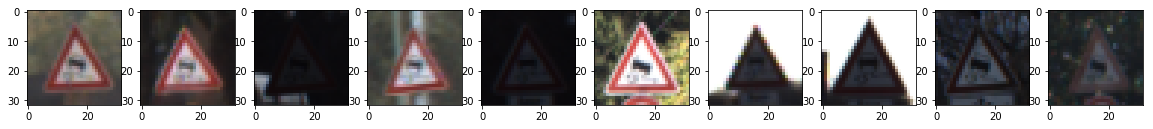

In [17]:
def click_on_button(class_id, norm_hist):
    plt.figure(figsize=(20,5))
    n = 10
    selected = train_set.loc[train_set['ClassId'] == class_id]
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = misc.imresize(misc.imread(selected.iloc[i]['Path'] + selected.iloc[i]['Filename']), (NORM_W, NORM_H))
        if norm_hist:
            img = exposure.equalize_hist(img)
        plt.imshow(img)

interact(click_on_button, 
         class_id={label : class_id for (class_id, label) in enumerate(label_names)},
         norm_hist = False
        )


# Generator
When we are working with a lot of data, we don't want to store everything in memory. Python generators let load data during on-the-fly (for example, during large loops)

In [11]:
# the generator
def generator(df, batch_size=100):
    while 1:
        df = df.sample(frac=1)
        X, Y = [], []
        for i in range(batch_size):
            img = misc.imresize(misc.imread(df.iloc[i]['Path'] + df.iloc[i]['Filename']), (NORM_W, NORM_H))
            img = exposure.equalize_hist(img)
            X.append(img)
            Y.append(df.iloc[i]['ClassId'])
        enc = preprocessing.LabelBinarizer()
        enc.fit(range(len(label_names)))

        yield np.float32(X), np.array(enc.transform(Y))
        

# Look on the data
This is the final output from the generator:
An X point as one piece of data (an image of the traffic sign, a 32x32x3 image);
and the corresponding Y label.

Y label is encoded in one-hot style, so it returns a vector with 0-s and a 1 on the corresponding label position.

In [19]:
n = 2
test_g = generator(train_set, batch_size = n)

X, Y = next(test_g)

print ('Sample X shape:', X[0].shape)
print ('Sample Y:', Y[0])

Sample X shape: (32, 32, 3)
Sample Y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0]


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


# The Keras model

In [20]:
model = Sequential()

model.add(Convolution2D(32,3,3, input_shape = (32, 32, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(128,3,3,))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(len(label_names)))

print (model.output)


Tensor("add_48:0", shape=(?, 43), dtype=float32)


# Training the model

In [21]:
gen = generator(train_set, batch_size=300)
val_gen = generator(test_set, batch_size=100)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch=3000, nb_epoch=10, validation_data=val_gen, nb_val_samples=100)



Epoch 1/10


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


3000/3000 [==============================] - 8s - loss: 0.0600 - acc: 0.0230 - val_loss: 0.0232 - val_acc: 0.0100
Epoch 2/10
3000/3000 [==============================] - 7s - loss: 0.0229 - acc: 0.0250 - val_loss: 0.0229 - val_acc: 0.0100

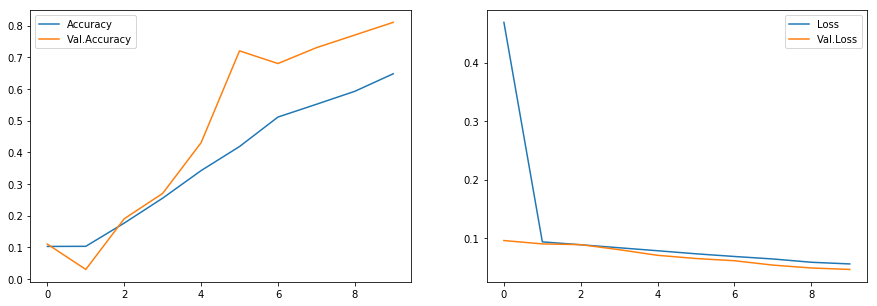

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Val.Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend()

In [22]:
####
####
history = model.fit_generator(gen, samples_per_epoch=30000, nb_epoch=10, validation_data=val_gen, nb_val_samples=100)


Epoch 1/10


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


30000/30000 [==============================] - 54s - loss: 0.0216 - acc: 0.1363 - val_loss: 0.0206 - val_acc: 0.1900

In [8]:
#saving the model
#model.save('./my_model43.h5')

In [12]:
#
model = load_model('./my_model43.h5')

In [13]:
# test

TEST_SIZE = 200
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

pr_get = generator(test_set, batch_size=TEST_SIZE)
X, Y = next(pr_get)

pr = model.predict(X)

pred_labels = np.argmax(pr, axis=1)
truth = np.argmax(Y, axis=1)

match_ratio = sum(pred_labels == truth)
print ('Matches: {} of {}; {} %'.format( match_ratio, TEST_SIZE, match_ratio / TEST_SIZE * 100) )


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Matches: 197 of 200; 98.5 %


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


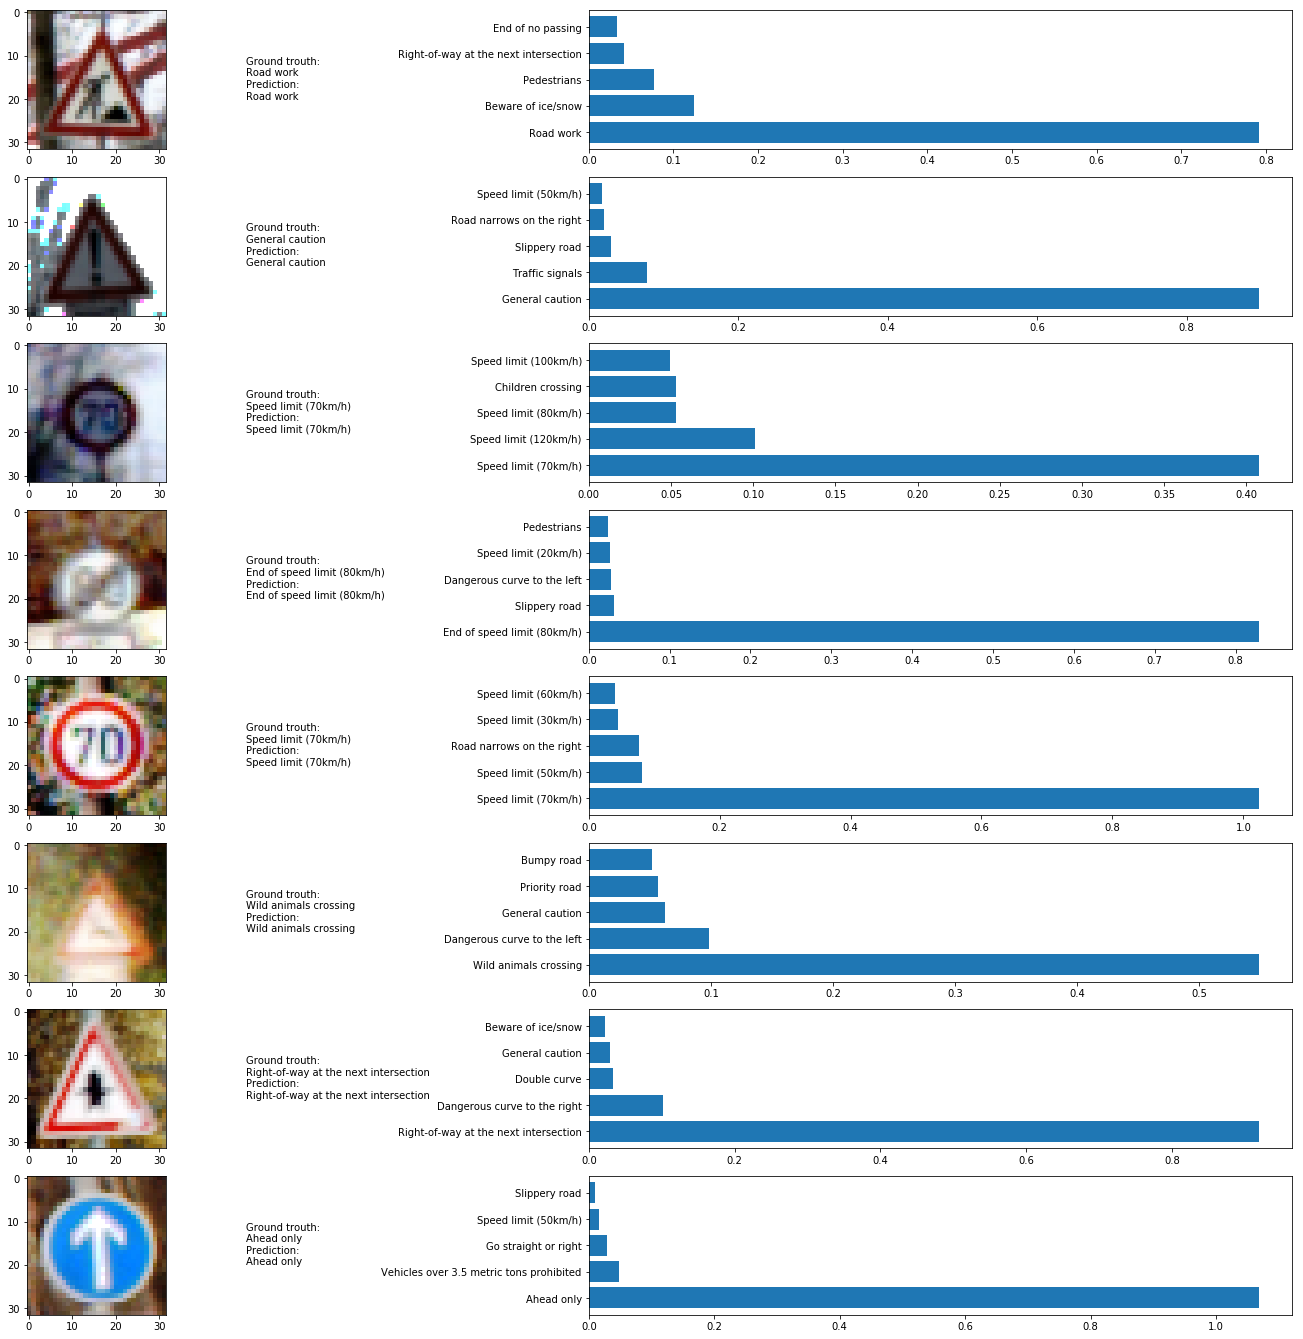

In [15]:


@interact(batch_size=8, n_best=5)
def vis_test(batch_size, n_best):
    plt.figure(figsize=(20,batch_size * 3))
    gen = generator(test_set, batch_size = batch_size)
    X, Y = next(gen)
    pr = model.predict(X)
    best_guesses = np.argsort(pr)
    
    for i in range(batch_size):
        plt.subplot(batch_size, 2, i*2 + 1)
        plt.imshow(X[i])
        
        true_label = label_names[np.argmax(Y[i])]
        pred_label = label_names[np.argmax(pr[i])]
        
        plt.text(50, 20, 'Ground trouth:\n{}\nPrediction:\n{} '.format(true_label,pred_label)  )
        plt.subplots_adjust(right=1.2)
        plt.subplot(batch_size, 2, i*2 + 2)
        guess_list = best_guesses[i][::-1][:n_best] #
        plt.barh(range(len(guess_list)), [pr[i][x] for x in guess_list])
        plt.yticks(range(len(guess_list)), [label_names[x] for x in guess_list])
        
